# Soma Detection Analysis of Whole-Brain Light-Sheet Images

In [1]:
from brainlit.preprocessing import removeSmallCCs
from brainlit.BrainLine.analyze_results import SomaDistribution
from brainlit.BrainLine.util import (
    json_to_points,
    download_subvolumes,
)
from brainlit.BrainLine.apply_ilastik import (
    ApplyIlastik,
    ApplyIlastik_LargeImage,
    plot_results,
    examine_threshold,
)
from brainlit.BrainLine.parse_ara import *
import xml.etree.ElementTree as ET
from cloudreg.scripts.transform_points import NGLink
from brainlit.BrainLine.imports import *

%gui qt5

## 1. Before Using this notebook

### 1a. Install brainlit, and other packages that this notebook uses
### 1b. Write images to s3 using CloudReg
    - e.g. python -m cloudreg.scripts.create_precomputed_volumes --s3_input_paths /mnt/NAS/SmartSPIM_Data/2022_03_02/20220302_14_40_04_8529_destriped_DONE/Ex_561_Em_600_stitched --s3_output_paths  s3://smartspim-precomputed-volumes/2022_03_02/8529/Ch_561_v2  --voxel_size 1.83 1.83 2 --num_procs 24 --resample_iso False
### 1c. Make point annotations in neuroglancer to identify subvolumes for validation (and possible training)
    - instructions: https://neurodata.io/help/neuroglancer-pt-annotations/
    ,
    {
    "type":"pointAnnotation",
    "name": "soma_val",
    "points": []
    },
    {
    "type":"pointAnnotation",
    "name": "nonsoma_val",
    "points":[]
    }
### 1d. Update soma_data.py file

### \* Inputs \*

In [2]:
brainlit_path = Path(os.path.abspath(""))
brainlit_path = brainlit_path.parents[1]
print(f"Path to brainlit: {brainlit_path}")
data_file = brainlit_path / "experiments" / "BrainLine" / "data" / "soma_data.json"

with open(data_file) as f:
    data = json.load(f)
brain2paths = data["brain2paths"]

Path to brainlit: /Users/thomasathey/Documents/mimlab/mouselight/brainlit_parent/brainlit


## 2. Download benchmark data

### \*Inputs\*

In [3]:
brain = "MS23"  # brain ID
soma_data_dir = "/Users/thomasathey/Documents/mimlab/mouselight/ailey/detection_soma/"  # path to directory where training/validation data should be stored
dataset_to_save = "val"  # train or val

antibody_layer = "Ch_647"
background_layer = "Ch_561"
endogenous_layer = "Ch_488"

### Setup paths

In [16]:
cvol_base = brain2paths[brain]["base"]
layer_names = [antibody_layer, background_layer, endogenous_layer]

### Download data

In [17]:
download_subvolumes(
    soma_data_dir,
    brain_id=brain,
    layer_names=layer_names,
    dataset_to_save=dataset_to_save,
    data_file=data_file,
)

fg shape: (7480, 10300, 3390, 1) at [1830. 1830. 2000.]
bg shape: (7480, 10300, 3390, 1) at [1830. 1830. 2000.]
endo shape: (7480, 10300, 3390, 1) at [1830. 1830. 2000.]
[10, 10] centers
Creating directory: /Users/thomasathey/Documents/mimlab/mouselight/ailey/detection_soma/brainMS23/val


Saving samples: 100%|██████████| 10/10 [12:48<00:00, 76.86s/it]


## 3. View downloaded data (optional)

### \*Inputs\*

In [ ]:
fname = "/Users/thomasathey/Documents/mimlab/mouselight/ailey/detection_soma/brainr2/val/891_4202_1717_pos.h5"  # path to file for viewing
scale = [1.8, 1.8, 2]  # voxel size in microns

In [ ]:
with h5py.File(fname, "r") as f:
    pred = f.get("image_3channel")
    image_fg = pred[0, :, :, :]
    image_bg = pred[1, :, :, :]
    image_endo = pred[2, :, :, :]

viewer = napari.Viewer(ndisplay=3)
viewer.add_image(image_fg, scale=scale)
viewer.add_image(image_bg, scale=scale)
viewer.add_image(image_endo, scale=scale)
viewer.scale_bar.visible = True
viewer.scale_bar.unit = "um"

## 4. Apply ilastik to validation data

You can do this programmatically (below), or you can use the ilastik GUI (which is sometimes faster)

### \* Inputs \*

In [4]:
model = "_rabies_pix_3ch"
project_path = f"/Users/thomasathey/Documents/mimlab/mouselight/ailey/detection_soma/matt_soma{model}.ilp"  # path to ilastik model to be used
ilastik_path = (
    "/Applications/ilastik-1.4.0b21-OSX.app/Contents/ilastik-release/run_ilastik.sh"
)
brains_path = "/Users/thomasathey/Documents/mimlab/mouselight/ailey/detection_soma/"
brains = [brain]

In [22]:
applyilastik = ApplyIlastik(
    ilastik_path=ilastik_path,
    project_path=project_path,
    brains_path=brains_path,
    brains=brains,
)
applyilastik.process_subvols(ncpu=6)
# applyilastik.move_results()

running ilastik...: 100%|██████████| 20/20 [02:49<00:00,  8.45s/it]


### \*Inputs (if relevant)\*
- identify files that have two somas in variable below. Since voxel coordinates are likely to be unique across samples, the file names below do not include sample IDs.

In [5]:
doubles = [
    "3972_1636_1575_pos_Probabilities.h5",
    "2867_4336_1296_pos_Probabilities.h5",
    "2607_1845_1309_pos_Probabilities.h5",
    "2101_3397_1747_pos_Probabilities.h5",
    "2011_3452_1911_pos_Probabilities.h5",
    "2113_3353_1727_pos_Probabilities.h5",
    "1968_3472_1784_pos_Probabilities.h5",
    "2589_5825_1626_pos_Probabilities.h5"
]  # 8446

## 5. Check Results

Processing Brains: 100%|██████████| 1/1 [00:02<00:00,  2.83s/it]


If this performance is not adequate, improve model and try again
                        ID  Recall  Precision
0   MS23 - FS: 0.95 @ 0.58     1.0   0.384615
1   MS23 - FS: 0.95 @ 0.58     1.0   0.357143
2   MS23 - FS: 0.95 @ 0.58     1.0   0.370370
3   MS23 - FS: 0.95 @ 0.58     1.0   0.476190
4   MS23 - FS: 0.95 @ 0.58     1.0   0.526316
5   MS23 - FS: 0.95 @ 0.58     1.0   0.500000
6   MS23 - FS: 0.95 @ 0.58     1.0   0.555556
7   MS23 - FS: 0.95 @ 0.58     1.0   0.555556
8   MS23 - FS: 0.95 @ 0.58     1.0   0.588235
9   MS23 - FS: 0.95 @ 0.58     1.0   0.625000
10  MS23 - FS: 0.95 @ 0.58     1.0   0.666667
11  MS23 - FS: 0.95 @ 0.58     1.0   0.714286
12  MS23 - FS: 0.95 @ 0.58     1.0   0.714286
13  MS23 - FS: 0.95 @ 0.58     1.0   0.714286
14  MS23 - FS: 0.95 @ 0.58     1.0   0.714286
15  MS23 - FS: 0.95 @ 0.58     1.0   0.714286
16  MS23 - FS: 0.95 @ 0.58     1.0   0.769231
17  MS23 - FS: 0.95 @ 0.58     1.0   0.769231
18  MS23 - FS: 0.95 @ 0.58     1.0   0.769231
19  MS23 - FS: 

(<Figure size 576x576 with 1 Axes>, 0.9523809523809523, 0.58)

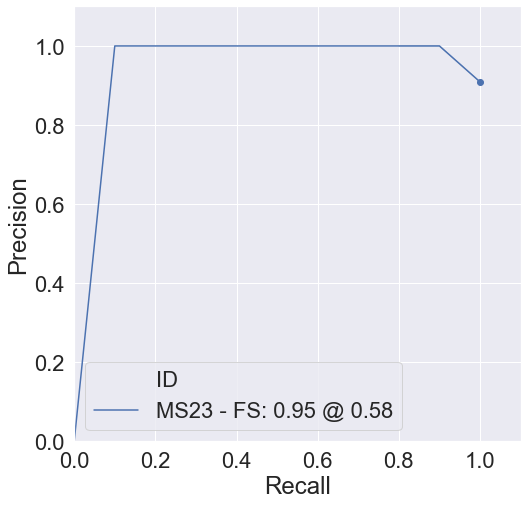

In [6]:
plot_results(
    data_dir=soma_data_dir,
    brain_ids=brains,
    object_type="soma",
    positive_channel=0,
    doubles=doubles,
)

In [ ]:
examine_threshold(
    data_dir=soma_data_dir,
    brain_id=brain,
    threshold=0.54,
    object_type="soma",
    positive_channel=0,
    doubles=doubles,
)

### Paper figure for all validation

In [ ]:
brain_ids = [
    "8607",
    "8606",
    "8477",
    "8531",
    "8608",
    "8529",
    "r1",
    "r2",
    "8446",
    "8454",
    "887",
    "MPRRabies",
    "969",
    "910",
]

plot_results(
    data_dir=soma_data_dir,
    brain_ids=brain_ids,
    object_type="soma",
    positive_channel=0,
    doubles=doubles,
)

## 6. Make Annotation layers

### Transformed layers

In [ ]:
atlas_vol = CloudVolume(
    "precomputed://https://open-neurodata.s3.amazonaws.com/ara_2016/sagittal_10um/annotation_10um_2017"
)
for layer in [
    antibody_layer,
    background_layer,
]:  # axon_mask is transformed into an image because nearest interpolation doesnt work well after downsampling
    layer_path = brain2paths[brain]["base"] + layer + "_transformed"
    info = CloudVolume.create_new_info(
        num_channels=1,
        layer_type="image",
        data_type="uint16",  # Channel images might be 'uint8'
        encoding="raw",  # raw, jpeg, compressed_segmentation, fpzip, kempressed
        resolution=atlas_vol.resolution,  # Voxel scaling, units are in nanometers
        voxel_offset=atlas_vol.voxel_offset,
        chunk_size=[32, 32, 32],  # units are voxels
        volume_size=atlas_vol.volume_size,  # e.g. a cubic millimeter dataset
    )
    vol_mask = CloudVolume(layer_path, info=info)
    vol_mask.commit_info()

## 7. Apply ilastik to whole image

### \* Inputs \*
You can use the notebook code below or the script using `soma_detect_image.py`

In [ ]:
brain = "test"
antibody_layer = "antibody"
background_layer = "background"
endogenous_layer = "endogenous"

threshold = 0.28  # threshold to use for ilastik
data_dir = "/Users/thomasathey/Documents/mimlab/mouselight/brainlit_parent/brainr_temp/"  # "/data/tathey1/matt_wright/brainr_temp/"  # directory to store temporary subvolumes for segmentation
results_dir = "/Users/thomasathey/Documents/mimlab/mouselight/brainlit_parent/brainr_results/"  # directory to store coordinates of soma detections

# Ilastik will run in "headless mode", and the following paths are needed to do so:
ilastik_path = "/Applications/ilastik-1.4.0b21-OSX.app/Contents/ilastik-release/run_ilastik.sh"  # "/data/tathey1/matt_wright/ilastik/ilastik-1.4.0rc5-Linux/run_ilastik.sh"  # path to ilastik executable
ilastik_project = "/Users/thomasathey/Documents/mimlab/mouselight/ailey/detection_soma/matt_soma_rabies_pix_3ch.ilp"  # "/data/tathey1/matt_wright/ilastik/soma_model/matt_soma_rabies_pix_3ch.ilp"  # path to ilastik project

max_coords = [3072, 4352, 1792]  # -1 if you want to process the whole dimension
ncpu = 1  # 16  # number of cores to use for detection
chunk_size = [256, 256, 256]  # [256, 256, 300]

In [ ]:
layer_names = [antibody_layer, background_layer, endogenous_layer]

ilastik_largeimage = ApplyIlastik_LargeImage(
    ilastik_path=ilastik_path,
    ilastik_project=ilastik_project,
    results_dir=results_dir,
    ncpu=1,
)
ilastik_largeimage.apply_ilastik_parallel(
    brain_id=brain,
    layer_names=layer_names,
    threshold=threshold,
    data_dir=data_dir,
    chunk_size=chunk_size,
    max_coords=max_coords,
)
ilastik_largeimage.collect_results(brain_id="test")

## 8. Register volume and transform data to atlas space using CloudReg

### 8a. You need to find an initial affine alignment using cloudreg.scripts.registration.get_affine_matrix. For example: 

A link to the ARA parcellation is:

`precomputed://https://open-neurodata.s3.amazonaws.com/ara_2016/sagittal_10um/annotation_10um_2017`

And some python commands to help with affine alignment is:

```
from cloudreg.scripts.registration import get_affine_matrix
get_affine_matrix([1,1,1], [0,0,0], "PIR", "RPI", 1.15, "precomputed://https://open-neurodata.s3.amazonaws.com/ara_2016/sagittal_10um/annotation_10um_2017")
```

### 8b. Run registration using cloudreg.scripts.registration. For example:

```
python -m cloudreg.scripts.registration -input_s3_path precomputed://s3://smartspim-precomputed-volumes/2023_04_14/MS25/Ch_561 --output_s3_path precomputed://s3://smartspim-precomputed-volumes/2023_04_14/MS25/atlas_to_target --atlas_s3_path https://open-neurodata.s3.amazonaws.com/ara_2016/sagittal_50um/average_50um --parcellation_s3_path https://open-neurodata.s3.amazonaws.com/ara_2016/sagittal_10um/annotation_10um_2017 --atlas_orientation PIR -orientation RPI --rotation 0 0 0 --translation 0 0 0 --fixed_scale 1. -log_s3_path precomputed://s3://smartspim-precomputed-volumes/2023_04_14/MS25/atlas_to_target --missing_data_correction True --grid_correction False --bias_correction True --regularization 5000.0 --iterations 3000 --registration_resolution 100
```

### 8c. Transform data to atlas space using CloudReg

### Soma coordinates

```
python -m cloudreg.scripts.transform_points --target_viz_link "https://viz.neurodata.io/?json_url=https://json.neurodata.io/v1?NGStateID=ziR1supw7MUOUg" --atlas_viz_link "https://ara.viz.neurodata.io/?json_url=https://json.neurodata.io/v1?NGStateID=HvyNDGaPsd1wyg" --affine_path /mnt/NAS/Neuroglancer\ Data/2023_04_14/MS25_Ch_561_registration/downloop_1_A.mat  --velocity_path /mnt/NAS/Neuroglancer\ Data/2023_04_14/MS25_Ch_561_registration/downloop_1_v.mat --transformation_direction "atlas"
```

or

```
python -m cloudreg.scripts.transform_points --target_viz_link https://viz.neurodata.io/?json_url=https://json.neurodata.io/v1?NGStateID=05Fhxt5VBT-_1A --atlas_viz_link https://ara.viz.neurodata.io/?json_url=https://json.neurodata.io/v1?NGStateID=HvyNDGaPsd1wyg --affine_path /cis/home/tathey/MPRRabies_Ch_561_registration/downloop_1_A.mat   --velocity_path /cis/home/tathey/MPRRabies_Ch_561_registration/downloop_1_v.mat  --transformation_direction atlas
```

This will produce a neuroglancer link with the transformed soma coordinates, which should be added to `soma_data.py` under the `somas_atlas_url` key. Then the code below, or `soma_brainrender.py`, can be used to visualize the data.

### Image

```
python -m cloudreg.scripts.transform_data --target_layer_source precomputed://s3://smartspim-precomputed-volumes/2023_03_15/969/Ch_561 --transformed_layer_source precomputed://s3://smartspim-precomputed-volumes/2023_03_15/969/Ch_561_transformed --affine_path /cis/home/tathey/887_Ch_561_registration/downloop_1_A.mat  --velocity_path /cis/home/tathey/887_Ch_561_registration/downloop_1_v.mat
```

or

```
python -m cloudreg.scripts.transform_data --target_layer_source precomputed://s3://smartspim-precomputed-volumes/2023_03_15/969/Ch_561 --transformed_layer_source precomputed://s3://smartspim-precomputed-volumes/2023_03_15/969/Ch_561_transformed --affine_path /mnt/NAS/Neuroglancer\ Data/969_Ch_561_registration/downloop_1_A.mat  --velocity_path /mnt/NAS/Neuroglancer\ Data/969_Ch_561_registration/downloop_1_v.mat
```

## 9. View results in brain space

### \*Inputs\*

In [10]:
brain_ids = [
    "8557",
    "8555",
    "8607",
    "8606",
    # "8477",
    # "8531",
    "8608",
    # "8529",
    # "8454",
    "MPRRabies",
    "969",
    "892",
    "MS37",
    "MS36",
    "MS25"
]

colors = {
    "tph2 vglut3": "blue",
    "tph2 gad2": "red",
    "gad2 vgat": "green",
}  # colors for different genotypes
symbols = ["o", "+", "^", "vbar", "diamond"]
fold_on = False
ontology_file = brainlit_path / "BrainLine" "data" / "ara_structure_ontology.json"

sd = SomaDistribution(brain_ids=brain_ids, data_file=data_file, ontology_file=ontology_file)

Brain 8557: Collecting atlas space soma points from layer: transformed_points
Brain 8555: Collecting atlas space soma points from layer: transformed_points
Brain 8607: Collecting atlas space soma points from file: /Users/thomasathey/Documents/mimlab/mouselight/ailey/detection_soma/wholebrain_results/atlas_somas_8607/transformed_points1.json
Brain 8607: Collecting atlas space soma points from file: /Users/thomasathey/Documents/mimlab/mouselight/ailey/detection_soma/wholebrain_results/atlas_somas_8607/transformed_points0.json
Brain 8607: Collecting atlas space soma points from file: /Users/thomasathey/Documents/mimlab/mouselight/ailey/detection_soma/wholebrain_results/atlas_somas_8607/transformed_points6.json
Brain 8607: Collecting atlas space soma points from file: /Users/thomasathey/Documents/mimlab/mouselight/ailey/detection_soma/wholebrain_results/atlas_somas_8607/transformed_points5.json
Brain 8607: Collecting atlas space soma points from file: /Users/thomasathey/Documents/mimlab/mo

Finding soma regions of brains: 100%|██████████| 11/11 [00:01<00:00,  5.84it/s]


In [ ]:
z_size = 1320
for z in tqdm(np.arange(0, z_size, 50)):
    sd.napari_coronal_section(
        z=z, subtype_colors=colors, symbols=symbols, fold_on=fold_on
    )

In [6]:
dir = "/Users/thomasathey/Documents/mimlab/mouselight/ailey/matt-coronals/"
z_size = 1320

for z in tqdm(np.arange(50, z_size, 50)):
    fname = dir + f"{brain}_{z}.tif"
    v = sd.napari_coronal_section(
        z=z, subtype_colors=colors, symbols=symbols, fold_on=False
    )
    im = v.screenshot(canvas_only=False)
    io.imsave(fname, im)

100%|██████████| 27/27 [05:30<00:00, 12.25s/it]


In [ ]:
sd.brainrender_somas(subtype_colors=colors)

## 10. Display bar charts

In [8]:
regions = [
    688,  # cerebral cortex
    95,  # agranular insular area
    714,  # orbital area
    698,  # olfactory areas
    1089,  # hippocampal formation
    # 583, # claustrum
    477,  # striatum
    # 803, # pallidum
    351,  # bed nuclei of stria terminalis
    # 703, #cortical subplate
    1097,  # hypothalamus
    157,  # periventricular zone
    515,  # medial preoptic nucleus
    290,  # hypothalamic lateral zone
    331,  # mammillary body
    797,  # zona incerta
    549,  # thalamus
    186,  # lateral habenula
    519,  # cerebellar nuclei
    846,  # dentate nucleus
    726,  # dentate gyrus
    313,  # midbrain
    157,  # inferior colliculus
    1052,  # pedunculopontine
    128,  # midbrain reticular nucleus
    214,  # red nucleus
    1065,  # hindbrain
    867,  # parabrachial nucleus
    701,  # vestibular nuclei
    972,  # prelimbic
    44,  # infralimbic
]  # allen atlas region IDs to be shown
# see: https://connectivity.brain-map.org/projection/experiment/480074702?imageId=480075280&initImage=TWO_PHOTON&x=17028&y=11704&z=3

composite_regions = {
    "Amygdalar Nuclei": [131, 295, 319, 780],
    "Substantia Nigra": [615, 374, 374],
    "Superior Colliculus": [294, 302],
}  # Custom composite allen regions where key is region name and value is list of allen regions

Populating: Cerebral cortex
Populating: Agranular insular area
Populating: Orbital area
Populating: Olfactory areas
Populating: Hippocampal formation
Populating: Striatum
Populating: Bed nuclei of the stria terminalis
Populating: Hypothalamus
Populating: Periventricular zone
Populating: Medial preoptic nucleus
Populating: Hypothalamic lateral zone
Populating: Mammillary body
Populating: Zona incerta
Populating: Thalamus
Populating: Lateral habenula
Populating: Cerebellar nuclei
Populating: Dentate nucleus
Populating: Dentate gyrus
Populating: Midbrain
Populating: Periventricular zone
Populating: Pedunculopontine nucleus
Populating: Midbrain reticular nucleus
Populating: Red nucleus
Populating: Hindbrain
Populating: Parabrachial nucleus
Populating: Vestibular nuclei
Populating: Prelimbic area
Populating: Infralimbic area
Populating: Amygdalar Nuclei
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04

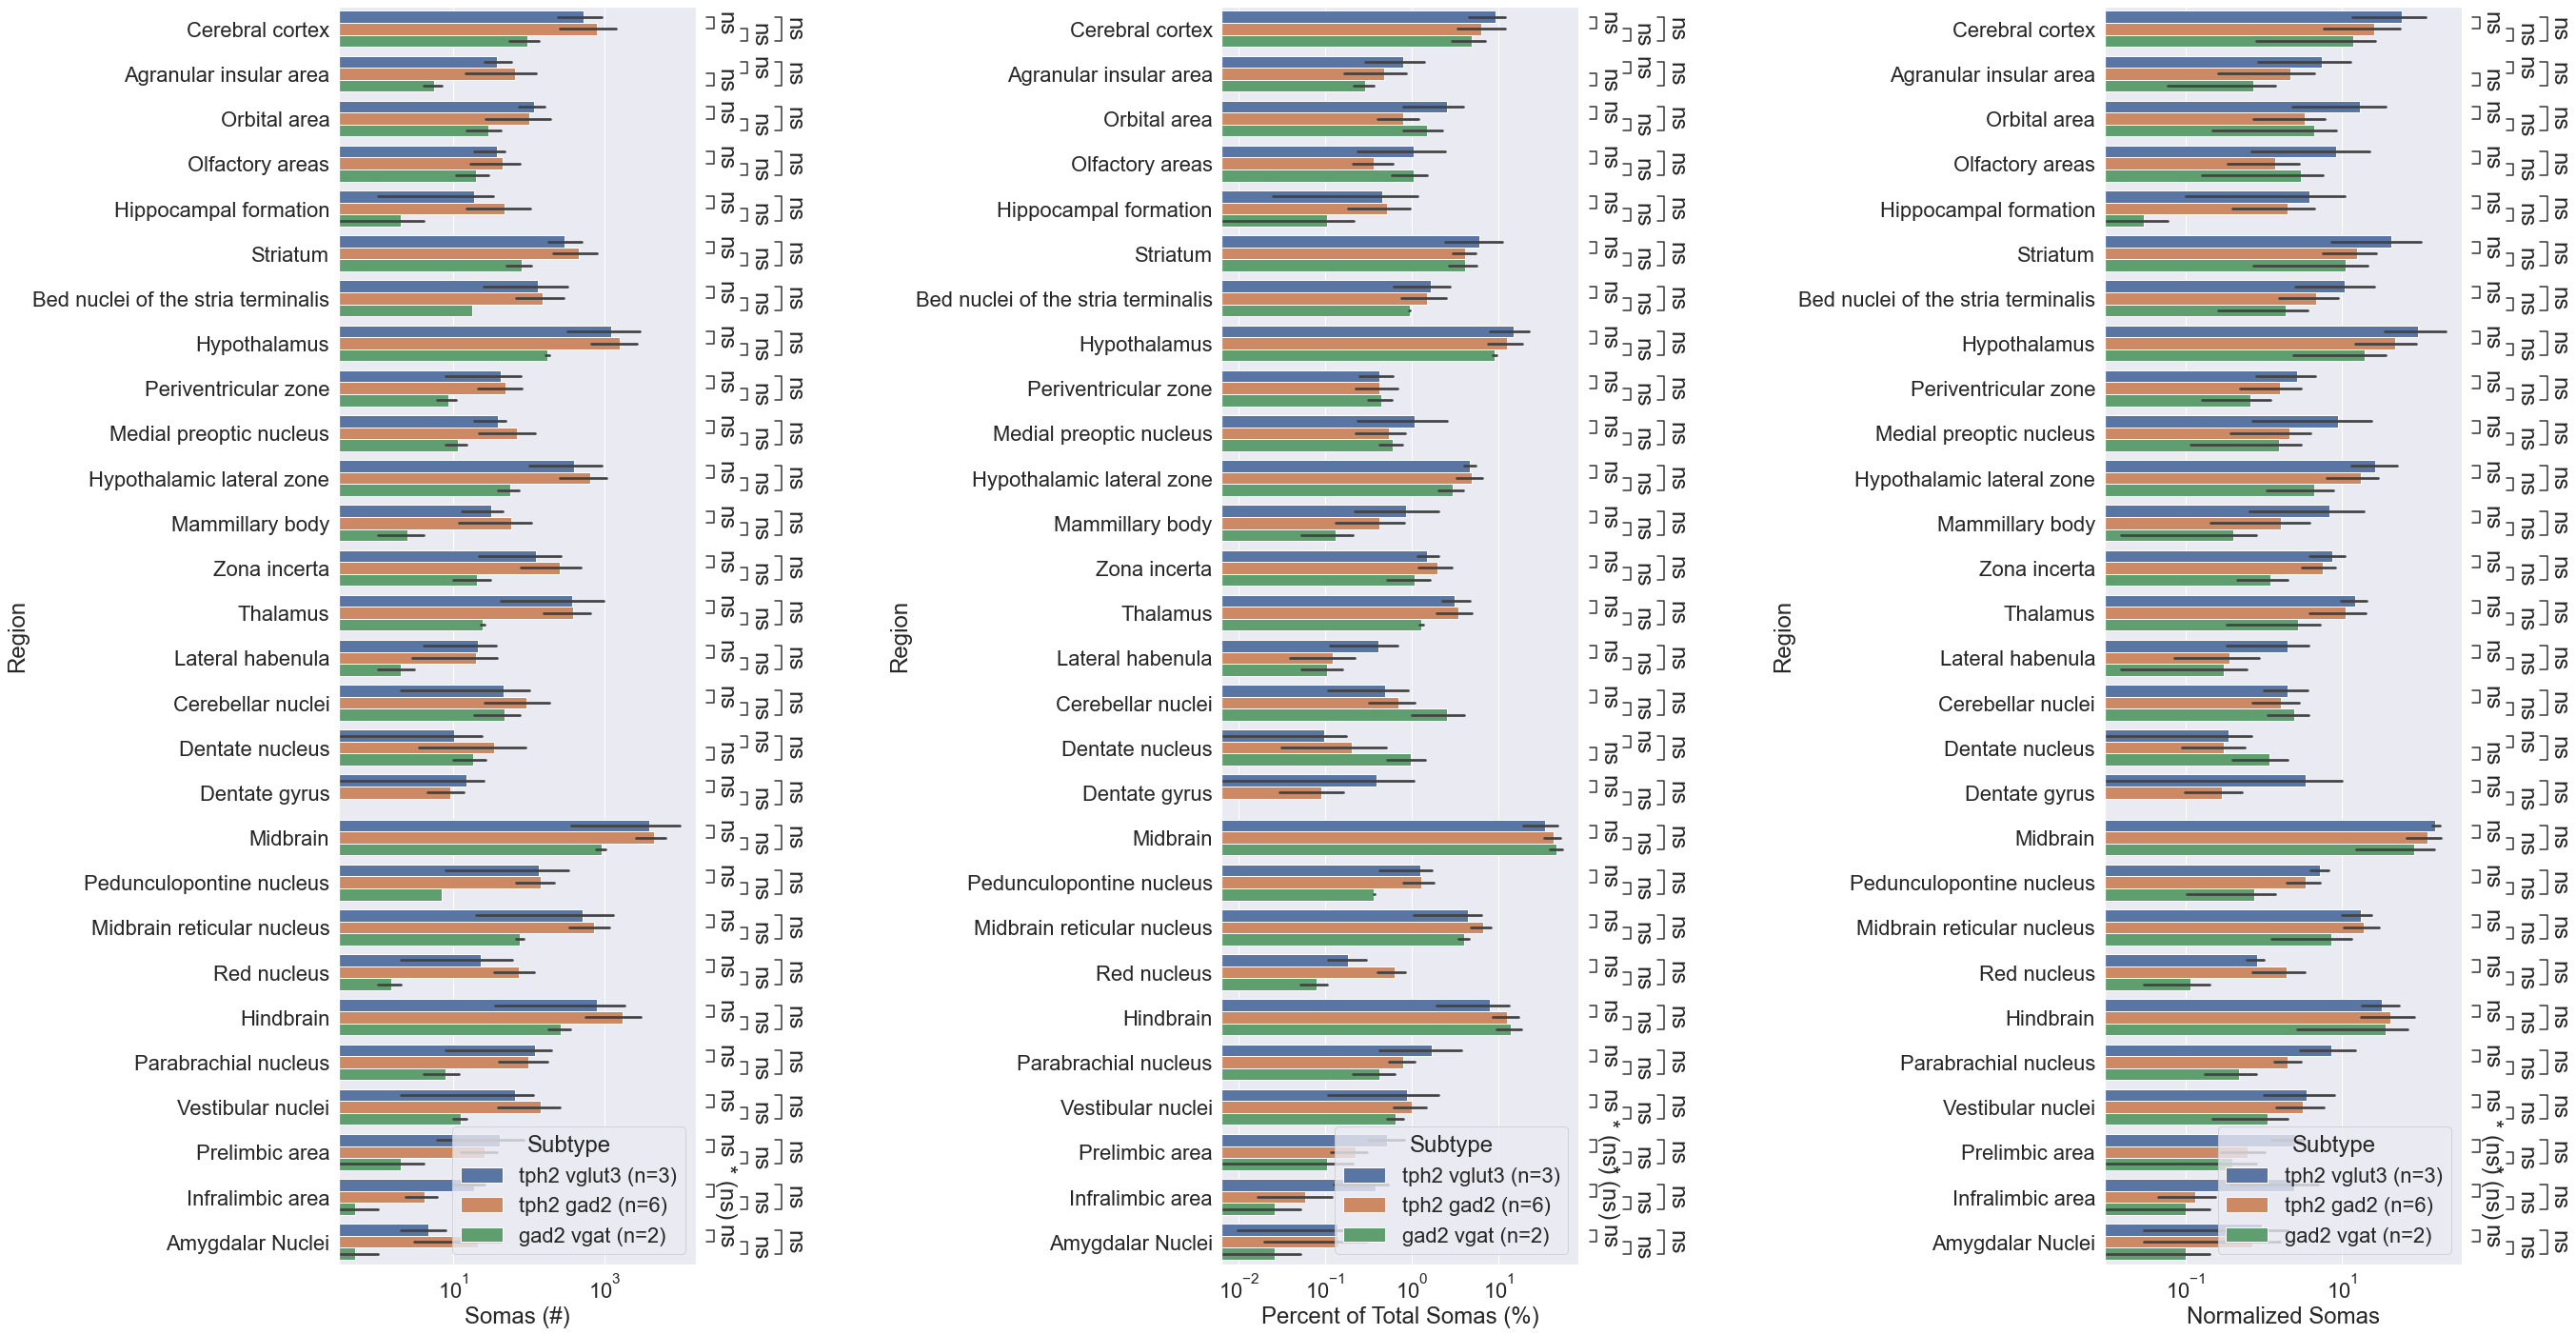

In [12]:
sd.region_barchart(regions, composite_regions=composite_regions, normalize_region=872)

### Hemisphere plots

In [14]:
sample_data = []
region_data = []
left_count_data = []
right_count_data = []
gtypes = []

for region in regions:
    for brain in brain_ids:
        sample_data.append(brain)
        region_data.append(region)
        left_count_data.append(sd.region_graph_l.nodes[region][brain])
        right_count_data.append(sd.region_graph_r.nodes[region][brain])
        gtypes.append(sd.brain2paths[brain]["subtype"])
data = {"Sample": sample_data, "Region": region_data, "Somas Left": left_count_data, "Somas Right": right_count_data, "Subtype": gtypes}

df = pd.DataFrame(data=data)

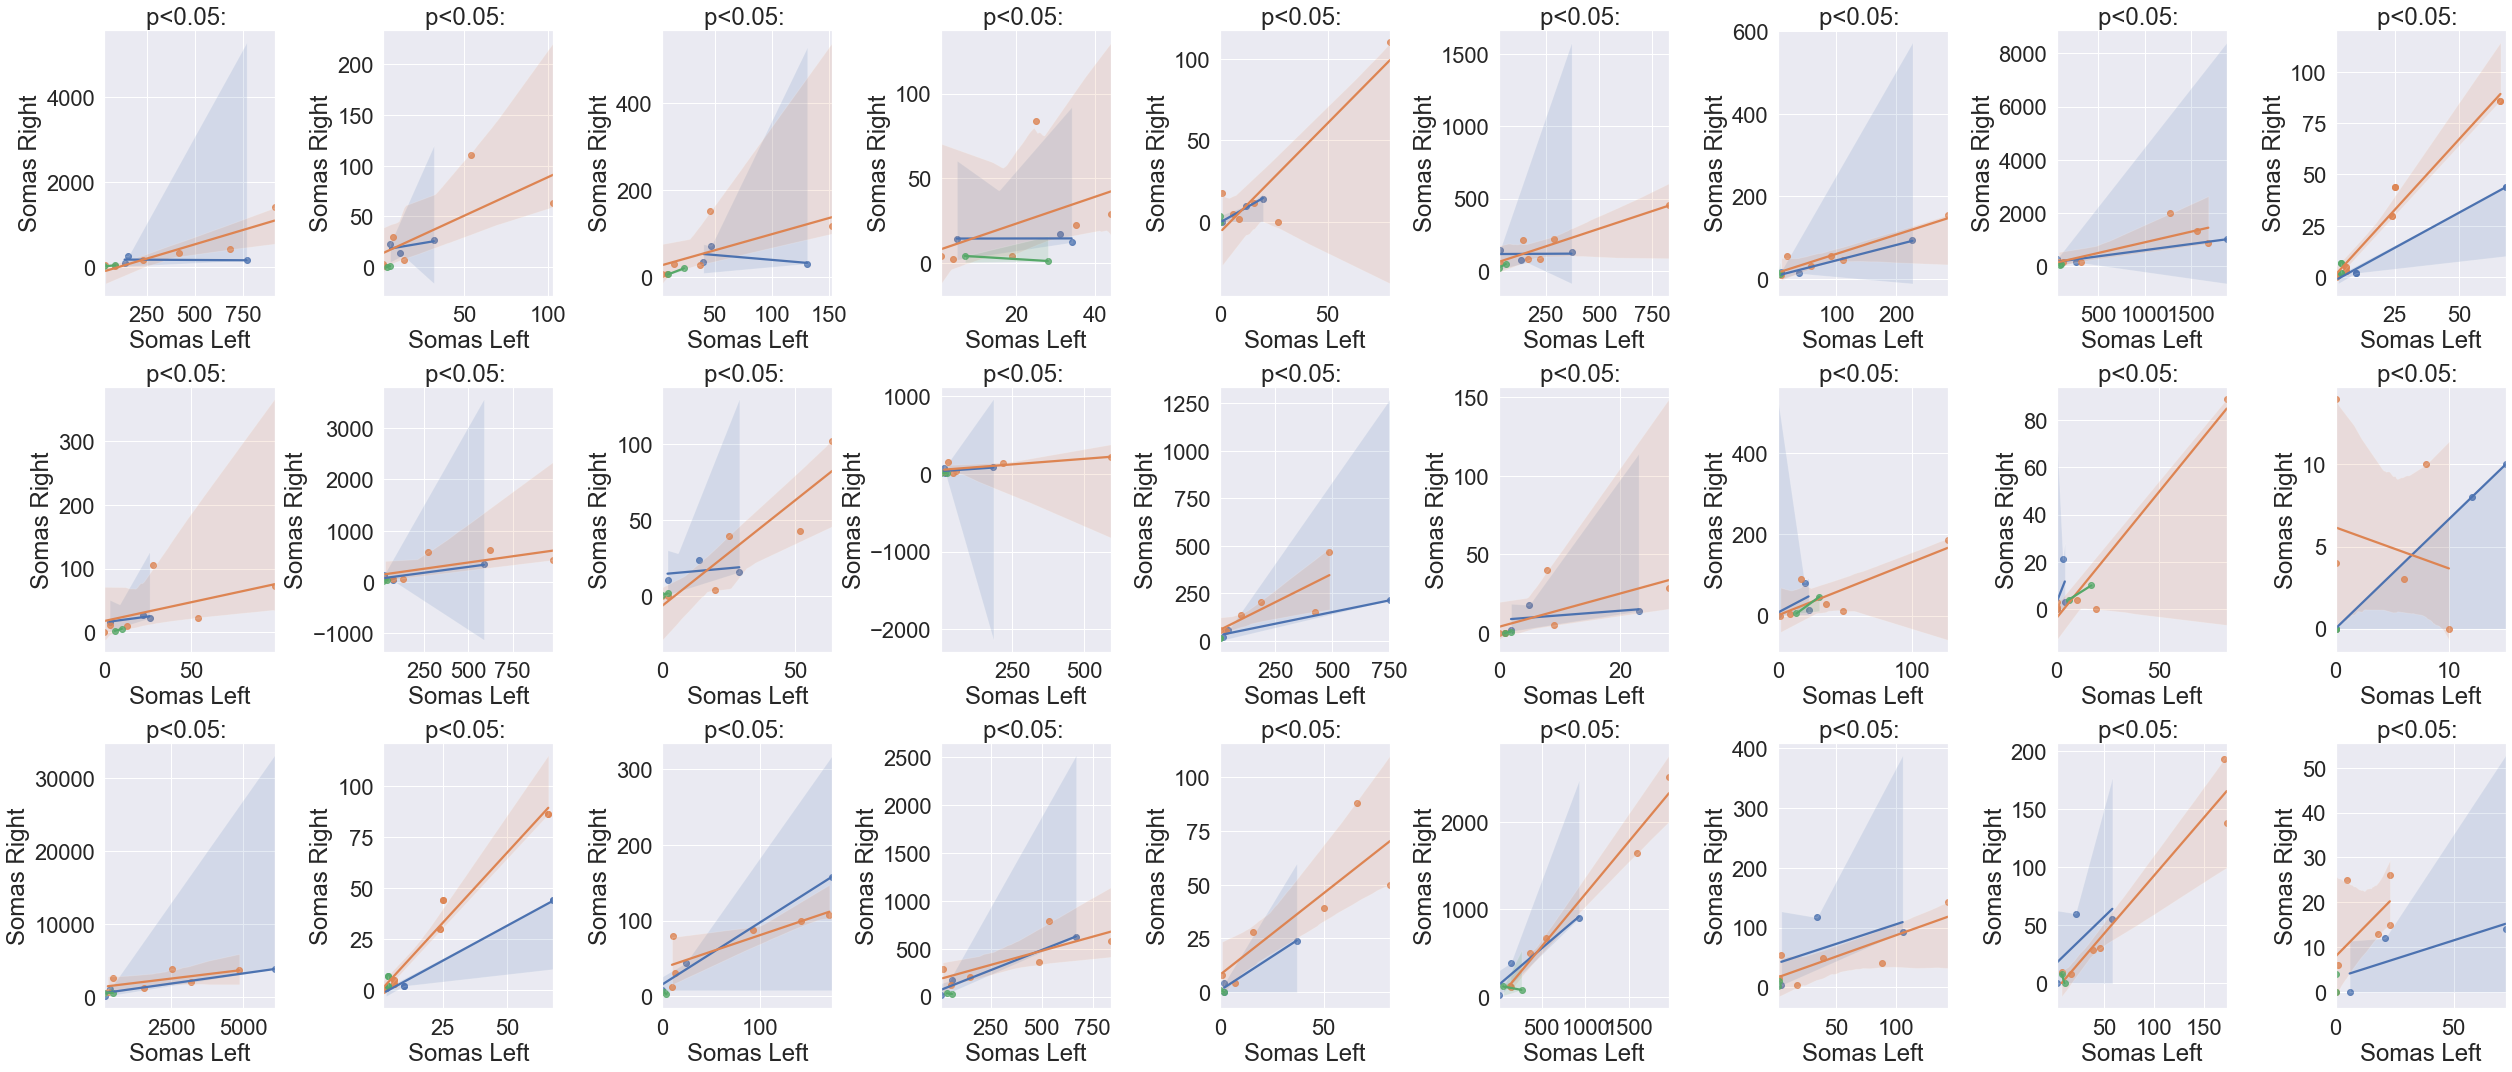

In [19]:
from scipy.stats import pearsonr
fig, axs = plt.subplots(3, 9)

for region, ax in zip(regions, axs.flatten()):
    for gtype in df["Subtype"].unique():
        df_r = df[df["Region"] == region]
        df_r = df_r[df_r["Subtype"] == gtype]
        graph = sns.regplot(data = df_r, x="Somas Left", y="Somas Right", ax = ax)
        r, p = pearsonr(df_r["Somas Left"], df_r["Somas Right"])
        txt = 'p<0.05: ' #f'{sd.region_graph.nodes[region]["name"]}: r={r:.2f}, p={p:.2f}'
        if p < 0.05:
            txt = txt + gtype
    ax.title.set_text(txt)

fig.set_figheight(15)
fig.set_figwidth(35)
plt.tight_layout()

### Compare distributions with PCA

In [ ]:
X = []
brain_ids = []
genotypes = []

for i, brain in enumerate(brains):
    print(brain)
    region_order = list(df.loc[df["Brain ID"] == brain]["Region"])

    if i == 0:
        standard_region_order = region_order
    elif standard_region_order != region_order:
        raise ValueError(f"Different region order for brain {brain}")

    distrib = list(df.loc[df["Brain ID"] == brain]["Percent of Total Somas (%)"])
    X.append(distrib)

    brain_ids.append(brain)
    genotypes.append(brains[brain])

X = np.array(X)

pca = PCA(n_components=2)
X_2 = pca.fit_transform(X)

df_pca = {
    "PC 1": X_2[:, 0],
    "PC 2": X_2[:, 1],
    "Genotype": genotypes,
    "Brain ID": brain_ids,
}
df_pca = pd.DataFrame(data=df_pca)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.scatterplot(data=df_pca, x="PC 1", y="PC 2", hue="Genotype", ax=ax)


for i in range(df_pca.shape[0]):
    plt.text(
        x=df_pca["PC 1"][i] + 0.03,
        y=df_pca["PC 2"][i] + 0.03,
        s=df_pca["Brain ID"][i],
        fontdict=dict(color="black", size=20),
    )

plt.title(
    f"Input Distribution PCA with Explained Variance: {pca.explained_variance_ratio_}"
)

## Create local volume

In [ ]:
vol = CloudVolume(
    "precomputed://s3://smartspim-precomputed-volumes/2022_03_10/8531/Ch_647_iso"
)

In [ ]:
subvol = vol[256 * 11 : 256 * 12, 256 * 16 : 256 * 17, 256 * 6 : 256 * 7]

In [ ]:
info = CloudVolume.create_new_info(
    num_channels=1,
    layer_type="image",
    data_type="uint16",  # Channel images might be 'uint8'
    encoding="raw",  # raw, jpeg, compressed_segmentation, fpzip, kempressed
    resolution=vol.resolution,  # Voxel scaling, units are in nanometers
    voxel_offset=vol.voxel_offset,
    chunk_size=vol.chunk_size,  # units are voxels
    volume_size=vol.volume_size,  # e.g. a cubic millimeter dataset
)

vol_ex = CloudVolume(
    "precomputed://file:///Users/thomasathey/Documents/mimlab/mouselight/brainlit_parent/brainlit/brainlit/BrainLine/data/example",
    info=info,
    compress=False,
)
vol_ex.commit_info()

In [ ]:
vol_ex[256 * 11 : 256 * 12, 256 * 16 : 256 * 17, 256 * 6 : 256 * 7] = subvol

In [ ]:
256 * 7

In [ ]:
vol = CloudVolume(
    "precomputed://file:///Users/thomasathey/Documents/mimlab/mouselight/brainlit_parent/brainlit/brainlit/BrainLine/data/example/endogenous",
    fill_missing=True,
)

### Post detections to ng

In [ ]:
brain_id = "8606"
all_somas_pth = f"/Users/thomasathey/Documents/mimlab/mouselight/ailey/detection_soma/wholebrain_results/all_somas_{brain_id}.txt"

from brainlit.BrainLine.data.soma_data import brain2paths
from cloudreg.scripts.transform_points import NGLink
from cloudreg.scripts.visualization import create_viz_link_from_json

coords = []
coords_target_space = []
file1 = open(all_somas_pth, "r")
lines = file1.readlines()
for line in tqdm(lines, desc="parsing coordinates", leave=False):
    if line != "\n":
        line = " ".join(line.split())
        elements = line.split(",")
        coord = [elements[0][1:], elements[1], elements[2][:-1]]

        coords.append([float(e.strip()) for e in coord])

coords = coords[15000:]
print(f"{len(coords)} detections")

ng_link = brain2paths[brain_id]["val_info"]["url"]
viz_link = NGLink(ng_link.split("json_url=")[-1])
ngl_json = viz_link._json

ngl_json["layers"] = [
    layer for layer in ngl_json["layers"] if layer["type"] != "annotation"
]

ngl_json["layers"].append(
    {"type": "annotation", "points": coords, "name": "detected_somas"}
)
viz_link = create_viz_link_from_json(
    ngl_json, neuroglancer_link="https://viz.neurodata.io/?json_url="
)
print(f"Viz link with detections: {viz_link}")